In this notebook, we are testing the ability to estimate phase lag on simulated data. The data is simulated according to the method proposed in Bharadwaj and Shin-Cunningham's paper.

Simulated SSSR recordings were produced by generating 32 channels of data with each containing a 200 ms burst of a 100 Hz sinusoid at a different randomly chosen phase (distributed uniformly around the circle). Background EEG-like noise was added to generate 200 simulated trials of raw EEG data. The noise had the same spectrum and spatial (between-channel) covariance as resting state EEG (note that the background cortical EEG activity is itself one of the primary sources of noise for SSSR measurements). The phase of the 100 Hz sinusoid (the SSSR signal of interest), though not aligned across channels, was kept constant across trials within each channel. The root-mean-squared (RMS) SNR for a single trial in each channel was set at −40 dB. This is comparable to typical SNRs for SSSRs obtained with our EEG setup, where the SSSR amplitude is typically on the order of hundreds of nanovolts, while the background, narrowband EEG amplitude is on the order of tens of microvolts. The SSSR was then extracted from the simulated data using traditional time-domain PCA as well as cPCA.

Notice that the noise had the same spectrum and spatial covariance as resting state EEG

The authors did not specify how it was achieved. To provide proper noise for simulation, we directly applied the resting state recording shared online.

https://github.com/mastaneht/SPIS-Resting-State-Dataset

In [1]:
cd

/home/luxx0489


In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from scipy.stats import circmean
from sklearn.cross_decomposition import CCA

data_path = './jupyter_projects/MultiChannelSSSR/SPIS-Resting-State-Dataset/Pre-SART EEG/'

In [3]:
mat_contents = loadmat(data_path + 'S02_restingPre_EO.mat')

The raw data in this file has been downsampled to 256 Hz from the original sampling rate of 2,048 Hz.

Channels 1 to 64 correspond to the monopolar EEG channels using the following channel names:

channelList = {'Fp1';'AF7';'AF3';'F1';'F3';'F5';'F7';'FT7';'FC5';'FC3';'FC1';'C1';'C3';'C5';'T7';'TP7';'CP5';'CP3';'CP1';'P1';'P3';'P5';'P7';. .. 'P9';'PO7';'PO3';'O1';'Iz';'Oz';'POz';'Pz';'CPz';'Fpz'; 'Fp2';'AF8';'AF4';'Afz';'Fz';'F2';'F4';'F6';'F8';'FT8';'FC6';'FC4';'FC2';'FCz';'Cz';... 'C2';'C4';'C6';'T8';'TP8';'CP6';'CP4';'CP2';'P2';'P4';'P6';'P8';'P10';'PO8';'PO4';'O2'};

Channels 65 to 67: Three surface EOG electrodes connected to the outer corners of the eyes and middle of the eyebrows.

Channel 68: The trigge channel.

In [6]:
freq = 100
x = np.linspace(0,52/256,52)
sample_signal = np.sin(x*freq*2*np.pi)

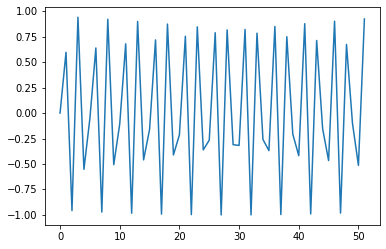

In [7]:
plt.plot(sample_signal)

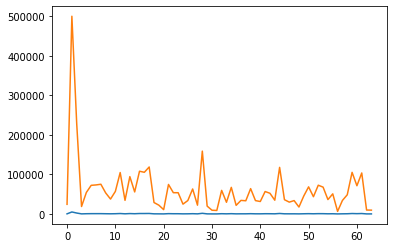

In [25]:
plt.plot(relative_levels*np.sqrt(np.mean(sample_signal**2)))
plt.plot(np.sqrt(np.mean(noise**2,1)))

In [10]:
np.random.seed(555)

phases = np.random.uniform(size=64)*2*np.pi

In [ ]:
noise = mat_contents['dataRest'][0:64,:]
noise = noise-np.reshape(noise.mean(1),(-1,1))

In [314]:
# prepare CCA
ref_list=[]

for iFreq in freq_x:
    tmp_ref = np.zeros((2,52))
    tmp_ref[0,:] = np.sin(x*iFreq*2*np.pi)
    tmp_ref[1,:] = np.cos(x*iFreq*2*np.pi)
    ref_list.append(tmp_ref)
    
cca = CCA(n_components=1)

In [310]:
nTrial = 200
freq = 98.46153846
mix = np.empty((nTrial,64,52))
noise_mat = np.empty((nTrial,64,52))

# fold noise
for iTrial in range(nTrial):
    for iChannel in range(64):
        noise_mat[iTrial,iChannel,:] = noise[iChannel,(iTrial*52):(iTrial+1)*52] - noise[iChannel,(iTrial*52):(iTrial+1)*52].mean()
        
noise_long = np.concatenate([noise_mat[iTrial,:,:] for iTrial in range(nTrial)], axis=1)

relative_levels = np.sqrt(np.mean(noise_long**2,1))/10/np.sqrt(np.mean(sample_signal**2))

# simulate data
for iTrial in range(nTrial):
    for iChannel in range(64):
        single_signal = np.sin(x*freq*2*np.pi + phases[iChannel])
        single_noise = noise_mat[iTrial,iChannel,:]
        mix[iTrial,iChannel,:] = relative_levels[iChannel]*single_signal + single_noise

# channel average PLV
freq_x = np.fft.rfftfreq(mix.shape[2],1/256)
xw = np.fft.rfft(mix, axis=2)
xw = xw/abs(xw)
plv_ave = xw.mean(0)

# cPCA
plv_mat=np.empty((64,xw.shape[2]),dtype=np.complex64)
v_mat = []
for iFreq in range(xw.shape[2]):
    csd = np.matmul(xw[:,:,iFreq].T,xw[:,:,iFreq].conj())
    w,v = np.linalg.eig(csd)
    v_mat.append(v)
    pc = np.matmul(v.conj().T,xw[:,:,iFreq].T)
    plv = (pc/abs(pc)).mean(1)
    plv_mat[:,iFreq] = plv

# concatenate and tPCA
mix_long = np.concatenate([mix[iTrial,:,:] for iTrial in range(nTrial)], axis=1)

w,v = np.linalg.eig(np.cov(mix_long))

pc = np.matmul(v,mix)

xw_pc = np.fft.rfft(pc, axis=2)
xw_pc = xw_pc/abs(xw_pc)
plv_ave_pc = xw_pc.mean(0)


In [316]:

plv_cca = []
for iFreq in range(len(freq_x)):
    cca.fit(mix[iTrial,:,:].transpose(),ref_list[iFreq].transpose())
    plv_cca.append(cca.score(mix[iTrial,:,:].transpose(),ref_list[iFreq].transpose()))

/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/sklearn/cross_decomposition/pls_.py:292: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/luxx0489/.conda/envs/mne/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'me

(10, 120)

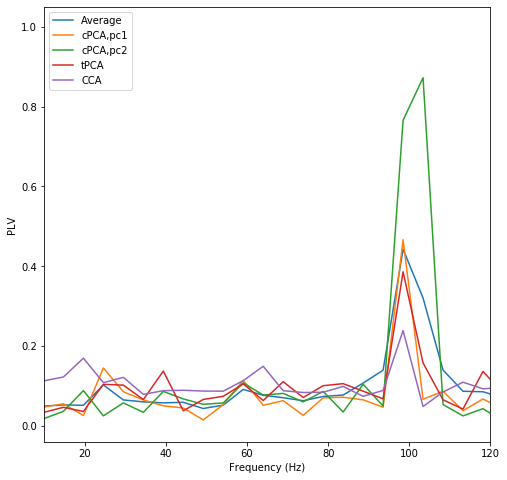

In [326]:
plt.figure(figsize=(8,8))
plt.plot(freq_x,abs(plv_ave).mean(0),label='Average')
plt.plot(freq_x,abs(plv_mat[0,:]),label='cPCA,pc1')
plt.plot(freq_x,abs(plv_mat[1,:]),label='cPCA,pc2')
plt.plot(freq_x,abs(plv_ave_pc[0,:]),label = 'tPCA')
plt.plot(freq_x,plv_cca,label='CCA')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('PLV')
plt.xlim(10,120)

Text(0, 0.5, 'Estimated Phase Shift (rad)')

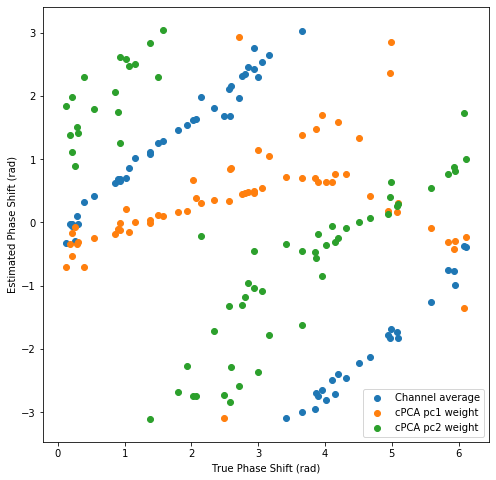

In [305]:
index = np.argmin(abs(freq_x-freq))
plt.figure(figsize=(8,8))
plt.scatter(phases,np.angle(plv_ave[:,index]),label='Channel average')
plt.scatter(phases,np.angle(v_mat[index][:,0]),label='cPCA pc1 weight')
plt.scatter(phases,np.angle(v_mat[index][:,1]),label='cPCA pc2 weight')

plt.legend()
plt.xlabel('True Phase Shift (rad)')
plt.ylabel('Estimated Phase Shift (rad)')

Text(0, 0.5, 'Absoulte Error in Phase Estimate (degrees)')

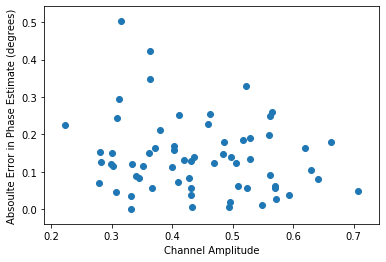

In [281]:
error = (phases-np.angle(plv_ave[:,index]))%(2*np.pi)
         
plt.scatter(np.abs(plv_ave[:,index]),np.abs(error-error.mean()))
plt.xlabel('Channel Amplitude')
plt.ylabel('Absoulte Error in Phase Estimate (degrees)')

Text(0, 0.5, 'Absoulte Error in Phase Estimate (degrees)')

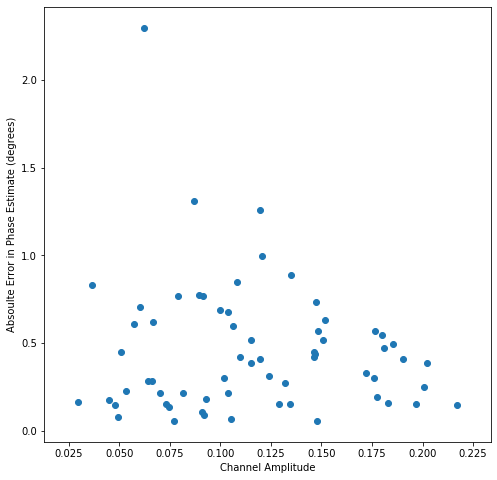

In [284]:
error = (phases-np.angle(v_mat[index][:,1]))%(2*np.pi)
plt.figure(figsize=(8,8))

plt.scatter(np.abs(v_mat[index][:,1]),np.abs(error-error.mean()))
plt.xlabel('Channel Amplitude')
plt.ylabel('Absoulte Error in Phase Estimate (degrees)')